In [3]:
import numpy as np
import joblib
from enum import Enum
import cv2
from joblib import Parallel, delayed
import os
from tqdm import tqdm

In [2]:
class DatasetTypes(Enum):
    IR_LGHT = "IR_LGHT"
    VIS_LGHT  = "VIS_LGHT"
    IR_VIS_LGHT = "IR_VIS_LGHT"

In [3]:
dataset_type = DatasetTypes.IR_VIS_LGHT
lightning_bucket_size = 50
lightning_min = 0
lightning_max = 450

In [4]:
class_names = [str(i) for i in range(lightning_min, lightning_max+lightning_bucket_size, lightning_bucket_size)] + ["None"]
class_names_path = os.path.join("../6Channel-PyTorch-YOLOv3/data/custom/","classes.names")
with open(class_names_path, "w") as class_names_file:
    class_names_file.writelines('\n'.join(class_names))

In [5]:
print(len(class_names))

11


In [6]:
def get_class_index(value, lightning_bucket_size=lightning_bucket_size, lightning_min=lightning_min, lightning_max=lightning_max):
    return np.clip((value//lightning_bucket_size),lightning_min//lightning_bucket_size,lightning_max//lightning_bucket_size)

In [7]:
data = joblib.load("../lght_vis_ir069_dataset_train_260000_.pickle")

In [2]:
import numpy as np

In [4]:
a = np.zeros((3,192,192))
b = np.zeros((3,192,192))
c = np.concatenate((a,b), axis=0)
c.shape

(6, 192, 192)

In [8]:
def process_datapoint_to_png(datapoint, dataset_type=dataset_type):
    name = datapoint[0]
    img_path_name = None
    if(dataset_type == DatasetTypes.IR_VIS_LGHT):
        #Todo
        img_path_name = os.path.join("../6Channel-PyTorch-YOLOv3/data/", "custom"+"/","images/" ,name+'.npy')
    else:
        img_path_name = os.path.join("../6Channel-PyTorch-YOLOv3/data/", "custom"+"/","images/" ,name+'.jpg')
    label_path_name = os.path.join("../6Channel-PyTorch-YOLOv3/data/", "custom"+"/","labels/" ,name+'.txt')
    img = None
    if(dataset_type == DatasetTypes.IR_LGHT):
        img = datapoint[1]
    if(dataset_type == DatasetTypes.VIS_LGHT):
        img = datapoint[2]
    if(dataset_type == DatasetTypes.IR_VIS_LGHT):
        img_1 = datapoint[1]
        img_2 = datapoint[2]
        img = np.concatenate((img_1, img_2), axis=2)
    label = datapoint[3]
    img_size = img.shape[0]
    #print(img.shape)
    label_keys = [key for key in label.keys() if type(key) is not str]
    normed_labels = []
    for label_key in label_keys:
        label_dict = label[label_key]
        xmin = label_dict["min_x"]
        ymin = label_dict["min_y"]
        xmax = label_dict["max_x"]
        ymax = label_dict["max_y"]
        center_x, center_y = ((xmin+xmax)/2, (ymin+ymax)/2)
        center_x_normed, center_y_normed = (center_x/img_size, center_y/img_size)
        width_x_normed, width_y_normed = ((xmax-xmin)/img_size, (ymax-ymin)/img_size)
        class_idx = get_class_index(label_dict["count"])
        normed_labels.append([str(class_idx), str(center_x_normed), str(center_y_normed), str(width_x_normed), str(width_y_normed)])
    if(len(normed_labels)==0):
#         return True
        normed_labels.append([str(len(class_names)-1),str(0.5),str(0.5),str(0.0052),str(0.0052)])
#     return False
    if(dataset_type != DatasetTypes.IR_VIS_LGHT):
        cv2.imwrite(img_path_name, 255*img)
    else:
        np.save(img_path_name, img)
    str_lines = [" ".join(row) for row in normed_labels]
    with open(label_path_name, "w") as label_file:
        label_file.writelines('\n'.join(str_lines))
    if(dataset_type == DatasetTypes.IR_VIS_LGHT):
        return name+".np"
    else:
        return name+".jpg"

In [9]:
train_names = Parallel(n_jobs=32, prefer="threads")(delayed(process_datapoint_to_png)(datapoint) for datapoint in tqdm(data))

100%|██████████| 260000/260000 [09:39<00:00, 448.29it/s]


In [10]:
# sum(train_names)

In [11]:
train_file_path = os.path.join("../6Channel-PyTorch-YOLOv3/data/", "custom"+"/","train.txt")
path_train_names = ["data/custom/images/"+train_name+"y" for train_name in train_names]
with open(train_file_path, "w") as train_file:
    train_file.writelines('\n'.join(path_train_names))

In [12]:
print(path_train_names[0])

data/custom/images/R19092420267860_time_48.npy


In [4]:
data = joblib.load("../lght_vis_ir069_dataset_test_10000_.pickle")

In [14]:
test_names = Parallel(n_jobs=32, prefer="threads")(delayed(process_datapoint_to_png)(datapoint) for datapoint in tqdm(data))

100%|██████████| 9999/9999 [00:27<00:00, 364.52it/s]


In [15]:
path_test_names = ["data/custom/images/"+test_name+"y" for test_name in test_names]

box at (92, 84) with count: 64
box at (64, 112) with count: 16


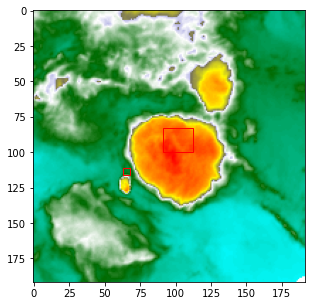

In [12]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
sample_img = None
for datapoint in data:
    #print(datapoint[0])
    if(datapoint[0] =="S840618_time_34"):
        fig,axs = plt.subplots(1,1,figsize=(5,5))
        axs.imshow(datapoint[1])
        sample_img = datapoint[1]
        labels = [label for label in datapoint[3].keys() if type(label) is not str]
        for label in labels:
            min_max_dict = datapoint[-1]
            start_x, start_y = min_max_dict[label]["min_x"], min_max_dict[label]["min_y"]
            length_x, length_y = min_max_dict[label]["max_x"] - start_x, min_max_dict[label]["max_y"] - start_y
            print("box at " + str((start_x, start_y)) + " with count: " + str(min_max_dict[label]["count"])) 
            #print((start_x, start_y, length_x, length_y))
            rect = patches.Rectangle((start_x-1, start_y-1),length_x+2,length_y+2,linewidth=1, edgecolor='r',facecolor='none')
            axs.add_patch(rect)

In [4]:
data = joblib.load("../lght_vis_ir069_dataset_test_10000_.pickle") + joblib.load("../lght_vis_ir069_dataset_train_260000_.pickle")

In [11]:
ids = []
for datapoint in data:
    if "S840618" in datapoint[0]:
        ids.append(datapoint[0])
ids

['S840618_time_34',
 'S840618_time_48',
 'S840618_time_18',
 'S840618_time_45',
 'S840618_time_46',
 'S840618_time_26',
 'S840618_time_40',
 'S840618_time_2',
 'S840618_time_8',
 'S840618_time_28',
 'S840618_time_6',
 'S840618_time_39',
 'S840618_time_32',
 'S840618_time_30',
 'S840618_time_5',
 'S840618_time_44',
 'S840618_time_9',
 'S840618_time_38',
 'S840618_time_25',
 'S840618_time_0']

In [16]:
test_file_path = os.path.join("../6Channel-PyTorch-YOLOv3/data/", "custom"+"/","valid.txt")
with open(test_file_path, "w") as test_file:
    test_file.writelines('\n'.join(path_test_names))

In [ ]:
def convert_to_norm_cmap(sevir_np_data, sevir_dtype):
    #print(sevir_np_data[:,:,0])
    cmap,norm,vmin,vmax = get_cmap(sevir_dtype)
    sm = matplotlib.cm.ScalarMappable(cmap=cmap,norm=norm)
    new_data = cv2.cvtColor(sm.to_rgba(sevir_np_data).astype(np.float32), cv2.COLOR_RGBA2RGB)
    print(new_data)
    #print(sm.to_rgba(sevir_np_data).shape)
    return cv2.cvtColor(sm.to_rgba(sevir_np_data).astype(np.float32), cv2.COLOR_RGBA2RGB)

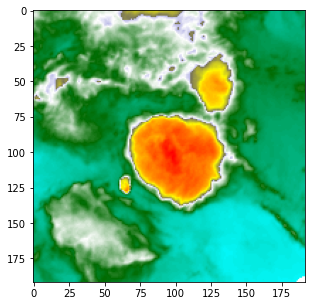

In [10]:
fig,axs = plt.subplots(1,1,figsize=(5,5))
axs.imshow(sample_img)

In [5]:
import rainymotion
from rainymotion.models import Dense


In [6]:
model = Dense()